In [10]:
import sys
import pandas as pd
import geopandas as gpd
from pathlib import Path
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 14})
from matplotlib.offsetbox import AnchoredText
import pickle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
sys.path.append(r'C:\Users\tacuevas\Documents\GitHub\concorde\modules')
from plots import scatter_interpolate
from mda import normalize_df
import seaborn as sns
from shapely.geometry import Point

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
## laad gpkg will considered tracks
gdf = gpd.read_file(r"C:\Users\tacuevas\NCSU\Research\Thesis\\STORM_NA_R4_IN_v6.gpkg")
## load time series of the tracks
dfall = pd.read_pickle(r"C:\Users\tacuevas\NCSU\Research\Thesis\STORM_NA_R4_InOut_v6.pkl")
## load reduced dataset (input of MDA)
dfpnt = pd.read_pickle(r'C:\Users\tacuevas\NCSU\Research\Thesis\STORM_NA_R4_In_pnt_v6_inpMDA.pkl')
## load clusters
dfcl = pd.read_pickle(r"C:\Users\tacuevas\NCSU\Research\Thesis\STORM_NA_R4_In_pnt_v6_Clusters_MDAvec_12params_1000.pkl")

In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [95]:
dfpnt_mean = dfpnt.iloc[:, :-1].mean(axis = 0)
dfpnt_std = dfpnt.iloc[:, :-1].std(axis = 0)

dfcl_dist = pd.DataFrame(index = dfcl.index, columns = dfcl.columns[:-4])

for col in dfcl_dist.columns:
    dfcl_dist[col] = np.sqrt((dfcl[col] - dfpnt_mean[col])**2) / dfpnt_std[col]
    
dfcl_dist['tc_number'] = dfcl['tc_number']

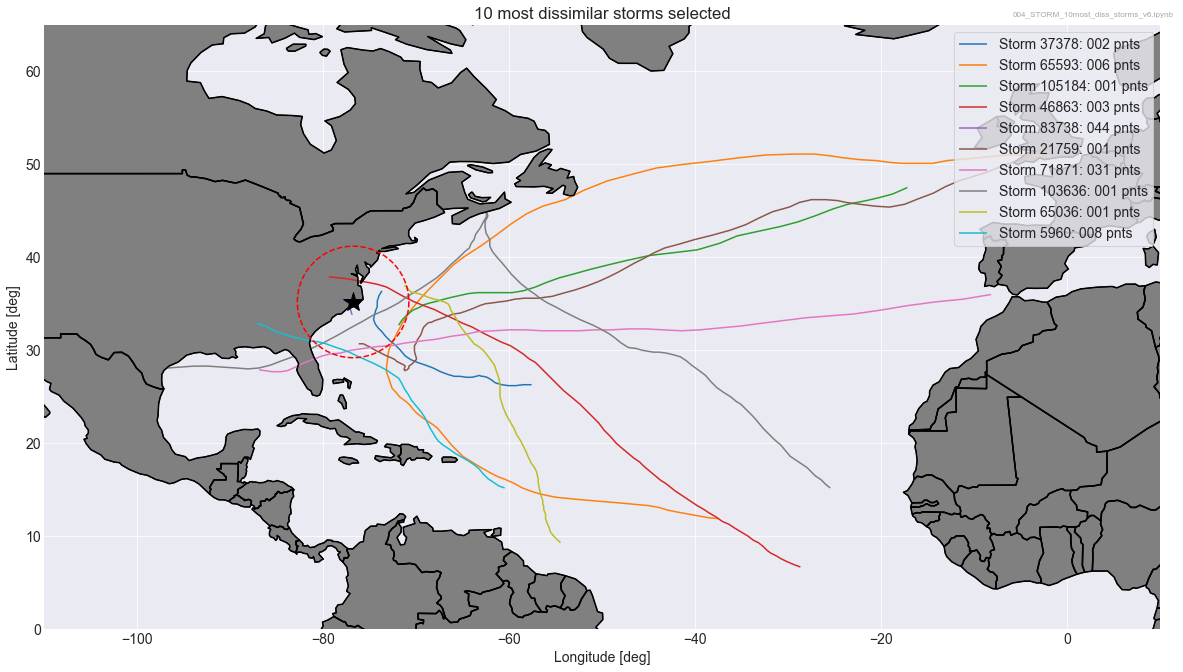

In [57]:
lab = [f'Storm {sid:0.0f}: {x:03d} pnts' for sid, x in zip(dfcl['tc_number'][:10], dfcl['npoints'][:10])]

nc = Point((-76.8, 35.2))
box = gpd.GeoDataFrame(geometry = [nc.buffer(6)])

fig, ax = plt.subplots(figsize = (20, 20))
for ig, g in enumerate(dfcl['tc_number'][:10]):
    gdf[gdf['tc_number'] == g].plot(ax = ax, legend = True, color = colors[ig])
world.plot(ax = ax, color = 'grey', edgecolor = 'k')
world.boundary.plot(ax = ax, color = 'k')
box.boundary.plot(ax = ax, color = 'r', ls = '--')
ax.plot([-76.8], [35.2], color = 'k', marker = '*', ms = 20)
ax.set_xlim([-110, 10])
ax.set_ylim([0, 65])
ax.set_aspect('equal')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.set_title('10 most dissimilar storms selected')

ax.legend(lab, frameon = True)
# leg = ax.get_legend()
# leg.get_frame().set_edgecolor('k')
# leg.get_frame().set_facecolor('w')
# leg.set_frameon(True)
# leg.set_bbox_to_anchor((1.1, 0.6))

text = AnchoredText(nb_name, 'upper right',frameon = False, borderpad = -2, prop=dict(fontsize = 'xx-small', alpha = 0.4))
ax.add_artist(text)
## add starting point

In [98]:
dfext = pd.DataFrame(index = dfcl_dist['tc_number'], columns = [f'Ext{x}' for x in range(1, 6)])
for i, j in enumerate(dfcl_dist.index):
    dfext.iloc[i, :] = dfcl_dist.iloc[[i], :-1].T.sort_values(by = [i], ascending = False).index[:5]

In [105]:
import os

In [109]:
os.getcwd()

'C:\\Users\\tacuevas\\NCSU\\Research\\Thesis\\code'

In [103]:
dfext.head(10)

,Ext1,Ext2,Ext3,Ext4,Ext5
tc_number,,,,,
37378.0,lat_gen,landfall,min_press_at_min_distNC,lat_at_min_distNC,lon_at_min_distNC
65593.0,min_press_at_min_distNC,lon_gen,duration,lon_at_min_distNC,rad_to_max_ws_at_min_distNC
105184.0,rad_to_max_ws_at_min_distNC,forward_speed_at_min_distNC,landfall,lon_at_min_distNC,lat_gen
46863.0,rad_to_max_ws_at_min_distNC,lon_gen,lat_gen,lat_at_min_distNC,duration
83738.0,mean_curvature_roi,forward_speed_at_min_distNC,lat_gen,duration,trajectory_in_roi
21759.0,rad_to_max_ws_at_min_distNC,duration,lat_at_min_distNC,min_press_at_min_distNC,lat_gen
71871.0,lat_at_min_distNC,min_press_at_min_distNC,lon_gen,forward_speed_at_min_distNC,rad_to_max_ws_at_min_distNC
103636.0,lon_gen,duration,min_press_at_min_distNC,forward_speed_at_min_distNC,lat_gen
65036.0,forward_speed_at_min_distNC,lat_gen,lon_at_min_distNC,lat_at_min_distNC,landfall


In [14]:
def sca(x, y):
    '''
    '''
    ix = list(dfcl.columns).index(x)
    iy = list(dfcl.columns).index(y)

    fig, ax = plt.subplots(figsize = (12, 8))
    ax.scatter(dfpnt[x], dfpnt[y], alpha = 0.2, c = 'k')
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    for i, index in enumerate(dfcl.index[:10]):
        ax.scatter([dfcl.iloc[i, ix]], [dfcl.iloc[i, iy]], c = colors[i], s = 100)

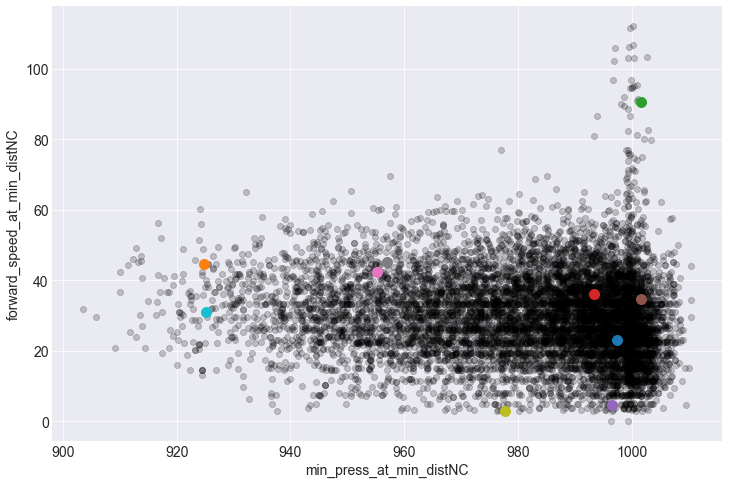

In [15]:
sca('min_press_at_min_distNC', 'forward_speed_at_min_distNC')

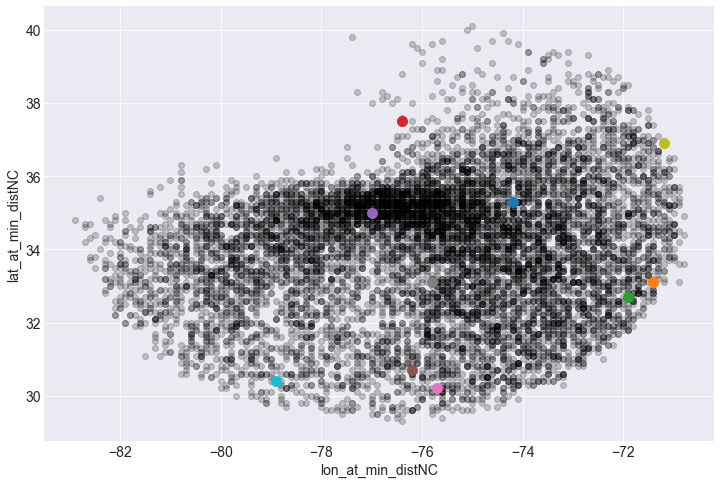

In [16]:
sca('lon_at_min_distNC', 'lat_at_min_distNC')